## RQ2

What are the time slots with more passengers? Set your own time slots and discover which are those when Taxis drive the highest number of passengers overall New York and repeat the analysis for each borough. Provide the results through a visualization and comment them.

In [2]:
''' imports '''
import pandas as pd
import numpy as np
from loader import Loader
import matplotlib.pyplot as plt
%matplotlib notebook

''' data paths '''
data = {
    'jan': {
        'path': 'data/yellow_tripdata_2018-01.csv',
        'start': '2018-01-01',
        'end': '2018-01-31'
    },
    'feb': {
        'path': 'data/yellow_tripdata_2018-02.csv',
        'start': '2018-02-01',
        'end': '2018-02-28'
    },
    'mar': {
        'path': 'data/yellow_tripdata_2018-03.csv',
        'start': '2018-03-01',
        'end': '2018-03-31'
    },
    'apr': {
        'path': 'data/yellow_tripdata_2018-04.csv',
        'start': '2018-04-01',
        'end': '2018-04-30'
    },
    'may': {
        'path': 'data/yellow_tripdata_2018-05.csv',
        'start': '2018-05-01',
        'end': '2018-05-31'
    },
    'jun': {
        'path': 'data/yellow_tripdata_2018-06.csv',
        'start': '2018-06-01',
        'end': '2018-06-30'
    }
}
locations = 'data/taxi_zone_lookup.csv'

# that's a list made by month_name and file_path to be fed to Loader
MONTHS = [(m, data[m]['path']) for m in data.keys()]

Let's load all months datasets, reading all of them as they're concatenated and in chunks composed by 100000 lines per single batch. Moreover, we'd like to merge 'taxi_zone_lookup.csv', we ask for precise columns and datetime parsing, and, finally, we get an iterator to access those data AIO.

**For more info about the Loader class, please, see the comments inside the 'loader.py'.**

In [2]:
# read data for each month
loader = Loader(csv=MONTHS, chunksize=100000)

# preparing locations to be merged on-the-fly when iterating
loader.merge(csv=locations, usecols=['LocationID', 'Borough'], on=('PULocationID', 'LocationID'), direction='left', drop_on_columns=True)

# get data generator
data_iterator = loader.iterate(usecols=['tpep_pickup_datetime', 'passenger_count', 'PULocationID'], parse_dates=['tpep_pickup_datetime'], date_index='tpep_pickup_datetime')

This code above could seem messy but it is necessary (could be improved for sure, though) to gather data from chunks.

The basic flow could be understood from comments below. The gathered data will be organized per each month, boroughs and days.

In [4]:
''' working with each borough '''
# declaring two counters to enhance verbosity
tot_rows = 0
processed_rows = 0

# count will be stored here
# and incremented chunk by chunk
h_slots_borough = {}

# iterate over chunks
for month, d in data_iterator:
    
    # info
    tot_rows += len(d.index)
    
    # remove older or newer items keeping only the ones
    # strictly related to the considered month
    d = d.loc[data[month]['start'] : data[month]['end']]
    
    # drop any row with missing values
    d = d.dropna()
    
    # processing each time slot
    # where time_span is the HH 
    # (es. 0 => 0:00 - 0:59 ...)
    for time_span in range(24):
        
        # creating valid hourly time slots for filtering purposes
        h_start, h_end = str(time_span) + ':00', str(time_span) + ':59'
        
        # filter DataFrame by time span
        f = d.between_time(h_start, h_end)
        
        # info
        processed_rows += len(f.index)
        
        # quantify passengers for each borough
        f_grouped = f.groupby('Borough')['passenger_count'].count()
        
        # iterate over each Borough
        # computer passenger_count and save it
        for borough in f_grouped.keys():
            p_count = f_grouped[borough]
            
            # create empty data structure to contain
            # hourly time_span info related to a borough
            if not borough in h_slots_borough:
                h_slots_borough[borough] = {}
            
            # add time_span if not already available
            # and increment the passenger_count
            if time_span not in h_slots_borough[borough]:
                h_slots_borough[borough][time_span] = p_count
            else:
                h_slots_borough[borough][time_span] += p_count

print(str(processed_rows) + ' over ' + str(tot_rows) + ' rows have been processed')

52950733 over 53825735 rows have been processed


In [5]:
''' create a DataFrame to easily be plotted '''
df = pd.DataFrame(h_slots_borough)

print(df)

    Queens  Bronx  Manhattan  Brooklyn  Unknown  EWR  Staten Island
0   114472   1901    1437770     43985    26369    7             37
1    55185   1636    1005549     30815    18700   11             40
2    26773   1379     728897     23173    13724   22             32
3    19030   1224     529067     18536    10471   36             41
4    26844   1496     409143     16534     8338  106             40
5    48868   1827     444178     11209     8466  122             52
6    82249   2507    1070705     22002    18114  167             16
7   115390   3879    1828641     31241    29168  162             20
8   121421   3626    2288285     36524    36128  138             25
9   137046   3047    2297576     26246    36935  152             42
10  152800   2596    2244594     19776    36947  144             45
11  138864   2322    2356606     18513    38946  164             35
12  153100   2438    2499522     20217    42539  205             29
13  164954   2421    2505492     21584    44429 

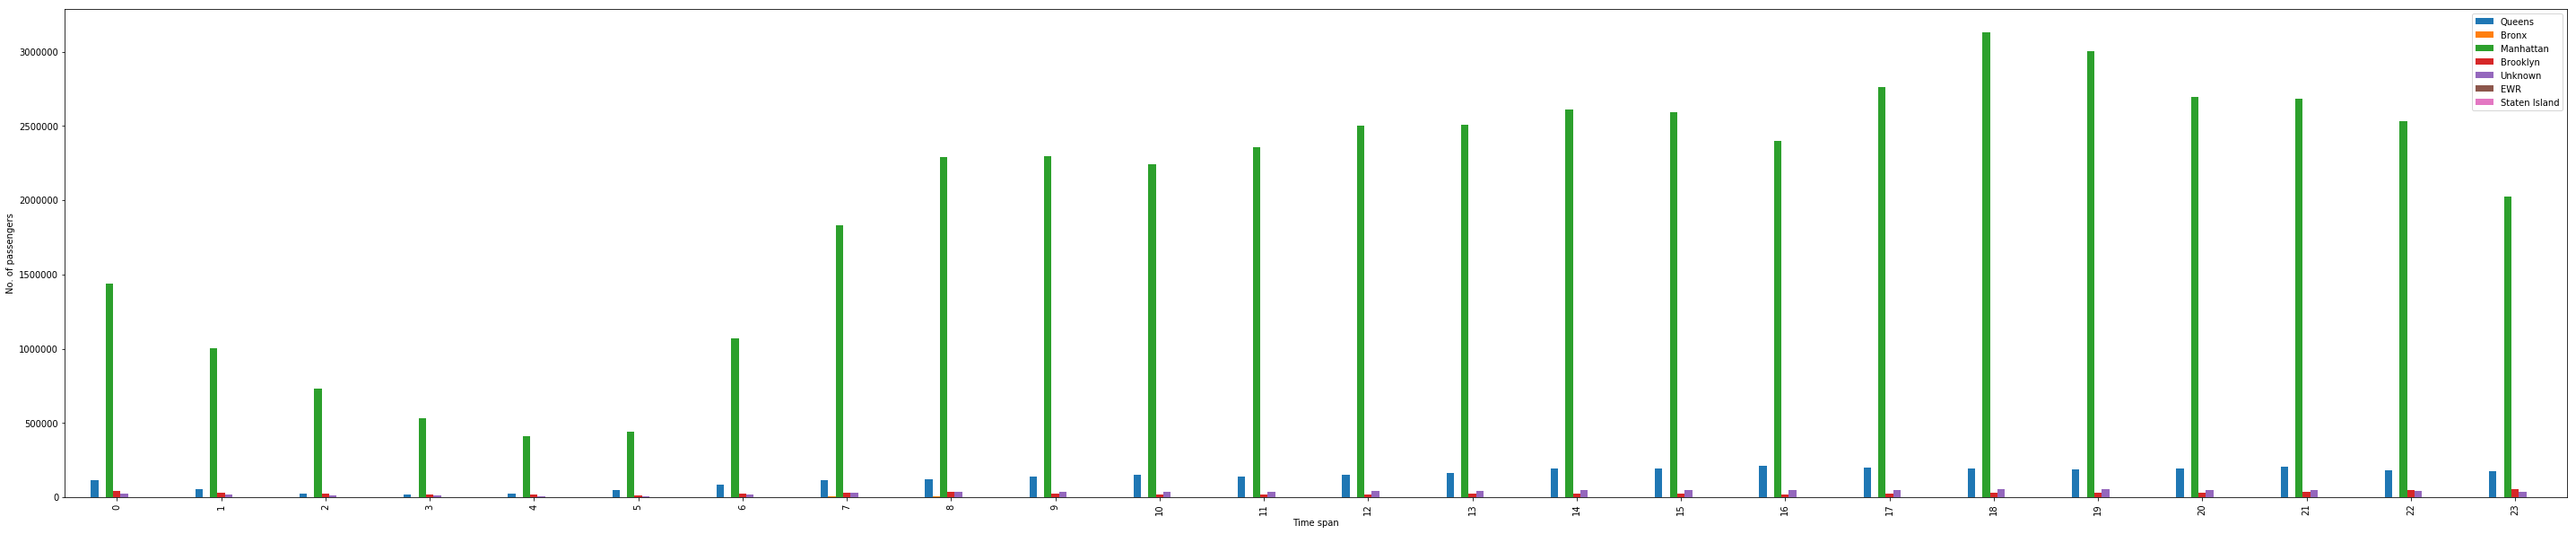

In [6]:
''' bar chart to show each borough '''

# plot prefs
figure, axes = plt.subplots(figsize=(50,10))
axes.set(xlabel='Time span', ylabel='No. of passengers')

# plotting...
df.plot.bar(ax=axes)

The plot above shows the dominance of Manhattan passengers in contrast with the ones in other boroughs. Generally speaking, the trend is *almost the same* within all boroughs, probably, beacuse of the common habits during the day of a generic NYC citizen. In fact, we can clearly infer that from 5:00 to 18:00 is a *crescendo* (ex. people waking up and going to work). In contrast, the decreasing phase starts from 19:00 to 4:00 (ex. people going home after work). 
Something curious, it's the fact that the amount of passengers is not sharply decreasing after working hours. That's probably because of the nightlife starting from about 21:00. 
Although it's been said before that the trend is almost the same for every borough, we could notice some differences after working hours (ex. notice the slight different trend between Brooklyn and Manhattan, where the first increases instead of decreasing like the second).

Even in this case, it is noteworthy a modest percentage of noise caused by Unknown-labeled data.

**To better dive into plot data, just run this notebook to deal with an interactive zoomable plot**

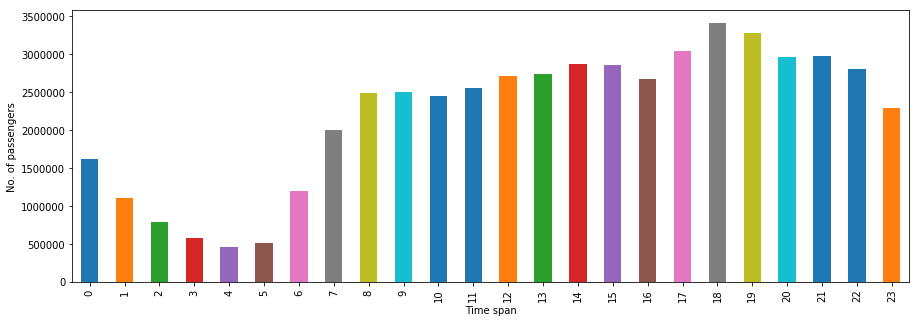

In [7]:
''' prepare DataFrame to an overall view (NYC) '''
# DOUBLE CLICK ON THE PLOT TO ZOOM IN/OUT!

# compute overall passenger_count
# (not based on boroughs)
df = df.sum(axis=1)

# plot prefs
figure, axes = plt.subplots(figsize=(15,5))
axes.set(xlabel='Time span', ylabel='No. of passengers')

# plotting...
df.plot.bar(ax=axes)

Overall, the trend is clearly common to all NYC. The city starts to wake up at 5:00 and rapidly reaches its full capacity. The peak is reached at 18:00 when people come back from work or, generally, to go home and have dinner. Even though, NYC is defined as *the city that never sleeps*, the sleep phase could be considered between 3:00 and 5:00, where the lowest value is found. 

**To better dive into plot data, just run this notebook to deal with an interactive zoomable plot**